# Behavior Response Time Modeling 

# Wald Distribution Intuition

The distribution we will be using to model response times is the shifted wald distribution defined as follows:

$$
f(x) = (\frac{\lambda}{2  \pi  (x-ndt)^3})^{\frac{1}{2}} * exp(\frac{-\lambda (x - ndt - \mu)}{2\mu^2(x-ndt)})
$$

If you are coming from a psychology background, you are likely familiar with the drift diffusion model (image credit: <a href="https://www.frontiersin.org/articles/10.3389/fninf.2013.00014/full">Thomas Wiecki & Michael Frank</a>)

<img src="https://www.frontiersin.org/files/Articles/55610/fninf-07-00014-HTML/image_m/fninf-07-00014-g001.jpg">

The DDM describes response accuracy and response times in forced two choice decision tasks. It involves an accumulation process that drifts towards one of two decision boundaries (DB) at a mean drift rate (DR) with added gaussian noise. This accumulation represents the decision process: evidence for a particular choice is accumulated until it passes a threshold where the decision is then executed. This could be either the correct choice or incorrect choice if noise overcomes the drift. Additionally, there is a non-decision time (NDT) parameter that models the non-decision components of response time including visual encoding and motor execution.

The DDM is a highly influential and widely used model. Though MSIT has three possible choices, the DDM still would be an excellent model for the data. However, the DDM requires a reasonable number of errors in order to estimate the incorrect response distribution. In our MSIT task, we have far too few errors.

The shifted Wald represents the single-choice analog of the DDM. With the shifted wald, we assume that evidence is being accumulated towards only a single decision boundary. This thus models the response times for correct choices. It is parameterized by a DB, DR, and NDT similarly to the DDM, but now there is only boundary. Note that in the above shifted wald equation, $\mu = DB/DR$, $\lambda = DB^2$, and ndt is simply NDT. 

EVIDENCE FOR SHIFTED WALD AS REASONABLE CHOICE

The cell below allows you to interactively change the parameters of the shifted wald to get a sense of how each affects the shape of the response time distribution. As you play with each parameter, make note of the following:
- NDT: This simply shifts the entire distribution to the right.
- DR: As this increases, the right tail of the distribution decreases and vice versa. Intuitively, this makes sense. The larger the drift rate, the less variation there will be from the noise since the drift rate will be dominant.
- DB: This is a bit more complex. As the decision boundary increases, the distribution becomes less skewed and more normal like. Additionally, it shifts the distribution to the right during this process. This ones a bit harder to intuit, but it makes some sense when we think it through. A larger decision boundary means that it will take longer to pass it assuming the same drift rate, which explains the rightwards shift. The change in the shape has to do with the relative ratio of the DB to DR. When the DB is smaller, the relatively larger DR makes it so that most of the drifts pass the threshold relatively quickly. However, as the DB increases with respect to DR, the amount of time for the noise to produce variations greatly increases, allowing more variation in both directions around the mean.

In [6]:
import sys
sys.path.append('../src')
from behavior import wald
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt

def plot_wald(db, dr, ndt):
    x = np.arange(ndt, 1.75, .001, dtype=np.float64)
    plt.plot(x, wald(x, db, dr, ndt))
    plt.xlim((0, 1.75))
    plt.show()
    
interact(plot_wald, db=(0, 5, .1), dr=(0, 8, .1), ndt=(0, 2, .01));

interactive(children=(FloatSlider(value=2.0, description=u'db', max=5.0), FloatSlider(value=4.0, description=u'dr', max=8.0), FloatSlider(value=1.0, description=u'ndt', max=2.0, step=0.01), Output()), _dom_classes=('widget-interact',))

# Model Structure

Now that we have some intuition for the wald distribution, the next step is to build our bayesian model for estimating the effects of the task manipulations on the wald response time distribution parameters.

Pictured below is a <a href="https://doingbayesiandataanalysis.blogspot.com/2012/05/graphical-model-diagrams-in-doing.html">kruscke diagram </a> of the model using the handy template provided <a href="http://www.sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/"> here </a>. It is a graphical depiction of all the variables in the model, their distributions, and their relationships.

<img src='../models/wald_hierarchical/wald_hierarchical.png'>

Here is the key for the diagram:
- s: subject s. This means that the variable varies between subject.
- m: modality m. This means that the variable varies between modalities.
- i: trial i. This means that the variable varies between trials.
- db: decision boundary
- rt: response time
- dr: drift rate
- ndt: non-decision time
- tt: trial type (0 = congruent, 1 = incongruent)

Key Model Structure:
- The core of the model is the wald likelihood. The RT distribution is modeled by a Wald distribution parameterized by a drift rate, decision boundary, and non-decision time (see above for info on the Wald distribution). 
- The decision boundary and drift rate are modeled via hierachical regressions across subjects with trial type as a predictor. The intercept terms, equivalent to the parameter values for congruent trials, have a group mean lognormal prior, and then individual subject parameters are drawn from a normal distribution with this mean. The beta term on the trial type has a regularized normal prior around 0. Note that the sum of the regression is constrained to be positive as both drift rate and decision boundary are strictly positive values. 
- The non-decision time parameters vary across each subject and modality. Each ndt term is drawn from a uniform distribution between 0 and the minimum response time for that subject for that modality. This constraint is necessary since by definition the non-decision time cannot be greater than the minimum response time.

Key Model Assumptions:
- We always make assumptions with the particular priors we choose. See below for a discussion of the chosen priors.
- Non-decision time does not vary between trial types. This is a fairly strong assumption. To be frank, this decision was largely made because it is difficult to model a regression on the non-decision times due to the variable constraints imposed by the varying minimum rt values. For the same reason, these weren't modeled hierarchically. That being said, given the stimuli are so similar between conditions and the response method is the same, it is not an entirely unreasonable assumption. A full suite of model comparisons should be done rather than making this assumption.
- Drift rate and decision boundary do not vary between modalities. Again, a deciding factor in this assumption was model tractability and this should really be answered with a suite of model comparisons. However, <a href="The impact of MRI scanner environment on perceptual decision-making"> this paper by van Maanen et al. </a> suggests that this may not be a completely unreasonable assumption. They use a linear ballistic accumulator model to show that it is primarily non-decision time increases due to increased response time that leads to slower RT's in the scanner. We observed this same effect. There modeling does suggest there could also be attentional effects that also affect drift rates, but the primary observation was on non-decision time.
- Subject decision boundaries and drift rates are drawn from a single gaussian group distribution. This makes the assumption that there is a single prototype of person in this task. However, one could imagine there being more groupings. For example, maybe there are some people who are overall just much more cautious compared to some who are not. This is probably a fairly reasonable assumption since people probably span the whole spectrum.
- This model completely ignores temporal effects and assumes that the generative model is the same for every trial. Of course, we know that this is not the case, but from our exploration we didn't find too many clear temporal effects and lacked the power to decompose a lot of the individual ones. To combat some of the global time trends, I detrend the data prior to fitting to avoid the spread caused by these trends to get absorbed into a parameter change. 

# Prior Information 

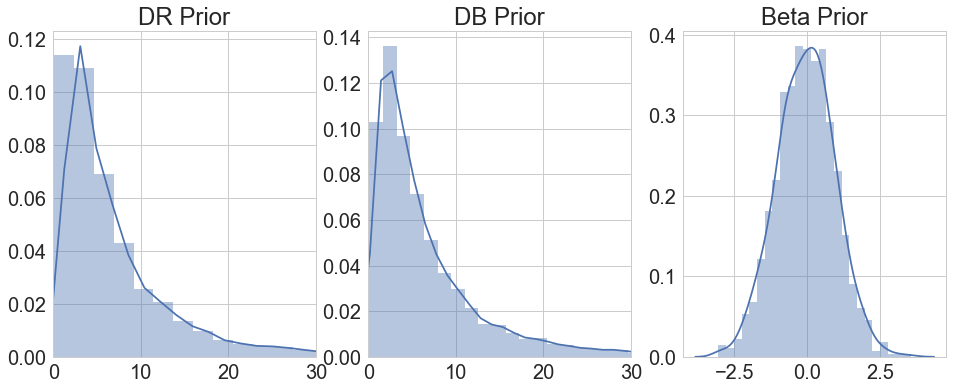

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, axs = plt.subplots(1, 3, figsize=(16, 6))

ax = axs[0]
samples = np.random.lognormal(1.5, 1, 10000)
sns.distplot(samples, ax=ax, bins=100)
ax.set_title('DR Prior')
ax.set_xlim((0, 30))

ax = axs[1]
samples = np.random.lognormal(1.5, 1, 10000)
sns.distplot(samples, ax=ax, bins=100)
ax.set_title('DB Prior')
ax.set_xlim((0, 30))

ax = axs[2]
samples = np.random.normal(0, 1, 1000)
sns.distplot(samples, ax=ax)
ax.set_title('Beta Prior')

plt.show();

# Model Fitting

Now that we have conceptualized and understood our model, the next step is to actually sample the parameter posteriors given our data. To do so we make use of the <a href="http://mc-stan.org/">stan package</a>. This is an amazing package that allows one to draw NUTS HMC samples from the posterior distribution of a bayesian specified in the stan modeling language. One first defines the model in a separate .stan file. This model is then compiled into C++ code and sampled via the <a href="https://pystan.readthedocs.io/en/latest/"> pystan</a> Python interface.

The following cells will fit and sample the model when run in order.

In [1]:
import pandas as pd
import sys
sys.path.append('../src')
from utils import select_subjects
from behavior import extract_summary, extract_samples
from behavior import detrend_data
import pickle
import os
import pystan
import json

# load config parameters
config = json.load(open('experiment_config.json', 'r'))
pystan_info = config['pystan_info']

model_name = 'wald_hierarchical'
model_dir = '../models/%s' % model_name
data_dir = '../data/derivatives/behavior/%s' % model_name
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Extract the Data 

The first step is to extract the data to be fit to be passed as a dictionary to the pystan sampler. The data must be organized as a dictionary with the keys matching the data variable names in the stan program.

Prior to extracting the data we:
- Exclude no response, error, post error, and fast rt trials
- Exclude bad subjects
- Globally de-trend the response time data for each subject, modality, trial type combination

In [2]:
# load in behavioral data and remove bad trials
data = pd.read_csv('../data/derivatives/behavior/group_data.tsv', sep='\t', 
                   na_values='n/a')
exclusions = ['no_response', 'error', 'post_error', 'fast_rt']
data = data[data[exclusions].sum(axis=1) == 0]

# exclude subjects
subjects = select_subjects('both')
data = data[data.participant_id.isin(subjects)]

# de-trend global effects
data = detrend_data(data)

# extract data for model
data_in = {}
data_in['Nt'] = data.shape[0]
data_in['rt'] = data.response_time
data_in['Ns']  = len(data.participant_id.unique())
data_in['min_rt_eeg'] = data[data.modality == 'eeg'].groupby(['participant_id']).response_time.min().as_matrix() - .001
data_in['min_rt_fmri'] = data[data.modality == 'fmri'].groupby(['participant_id']).response_time.min().as_matrix() - .001
data_in['sub_ix']= data.participant_id.astype('category').cat.codes + 1
data_in['tt']= data.trial_type.astype('category').cat.codes
data_in['mod']= data.modality.astype('category').cat.codes

## Compile the Model

The next step is to compile our stan model so that the sampler can sample it. This takes a few minutes, but makes the sampling much faster since it is in compiled C++ code. The compiler will also check for syntax errors, so this is an important debugging stage as well.

In [3]:
model_f = '%s/%s.stan' % (model_dir, model_name)
cache_f = '%s/%s.pkl' % (model_dir, model_name)

if not os.path.exists(cache_f):
    model = pystan.StanModel(file=model_f, model_name=model_name)
    pickle.dump(model, open(cache_f, 'w+'))
else:
    model = pickle.load(open(cache_f, 'r'))

## Sample the Model

Finally, we draw samples from the posterior of the model using Stan's NUTS HMC sampling algorithm. We first run several hundred warmup samples where some parameters for the algorithm are estimated and we allow time for the sampling to converge to the posterior. These are discarded and not included in our posterior estimate. We then sample the posterior from several chains in parallel. This speeds up the sampling process and also supports later convergence checks.

We had 10 cores available to us so we ran 10 chains with 2500 samples, the first 500 of which were discarded as warmup. This leaves us with 20000 samples drawn from the posterior. John Kruschke (author of Doing Bayesian Data Analysis) recommends having > 10,000 samples to reasonably estimate 95% HDI limits. 20000 samples is safely past this point with the assumption that our effective sample size percentage will be relatively high.

In [ ]:
fit = model.sampling(data=data_in, iter=pystan_info['niter'], 
                     warmup=pystan_info['nwarmup'],
                     chains=pystan_info['nchains'], init='random', seed=13)

# exclude helper variables
sample_exclude = ['mu', 'lambda', 'db', 'dr', 'ndt', 
                  'db_incongruent', 'dr_incongruent', 
                  'ndt_eeg_tmp', 'ndt_fmri_tmp']
summary_exclude = sample_exclude + ['rt_pred', 'log_lik']

samples = extract_samples(fit, sample_exclude)
samples.to_csv('%s/%s_samples.csv' % (data_dir, model_name), 
               index=False)

summary = extract_summary(fit, summary_exclude)
summary.to_csv('%s/%s_summary.csv' % (data_dir, model_name), 
               index=True)

# Model Diagnostics

After fitting the model, the next step is to assess the quality of the sampling process. This includes checking things such as proper convergence of the model, how well it fits the data, etc. Each section below provides a different diagnostic plot.

In [6]:
import pandas as pd
import sys
sys.path.append('../src')
from utils import select_subjects
from behavior import summary_plot, param_plot, wald, plot_ppc
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import os
import json

model_name = 'wald_hierarchical'
data_dir = '../data/derivatives/behavior/%s' % model_name

# load in behavioral data and remove bad trials
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv', sep='\t', 
                       na_values='n/a')
exclusions = ['no_response', 'error', 'post_error', 'fast_rt']
behavior = behavior[behavior[exclusions].sum(axis=1) == 0]

# exclude subjects
subjects = select_subjects('both')
behavior = behavior[behavior.participant_id.isin(subjects)]

behavior = detrend_data(behavior)

summary = pd.read_csv('%s/%s_summary.csv' % (data_dir, model_name),
                      index_col=0)
samples = pd.read_csv('%s/%s_samples.csv' % (data_dir, model_name))

## $\hat{R}$ Convergence

The $\hat{R}$ metric is a commonly used metric to assess the convergence of the sampling to the posterior. We throw away warmup samples to ensure that we only look at samples from the actual posterior. However, we need a way to ensure that we threw enough away and that our samples are actually converged.

$\hat{R}$ relies on the use of multiple chains sampling in parallel. Each chains is started from a different random point. The $\hat{R}$ metric then computes an ANOVA-like ratio of the between chains variance to the within chains variance. The closer to 1.00, the closer to convergence as 1.00 represents equal between and within variance. As $\hat{R}$ gets higher, this means the variance between chains is higher, indicating separation of the chains. The chains should all be converging to the same posterior, so separation between the chains implies they have not fully converged.

As can be seen below, with the exception of one subject's dr_intercept that is slightly high (~1.01), all of the parameters have well converged according to this metric.

In [7]:
def view_rhat(param_type):
    
    fig = summary_plot('Rhat', summary, param_type)
    plt.show()

interact(view_rhat, param_type=['db', 'dr', 'ndt'])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncGFyYW1fdHlwZScsIG9wdGlvbnM9KCdkYicsICdkcicsICduZHQnKSwgdmFsdWU9J2RiJyksIE91dHB1dCgpKSzigKY=


<function __main__.view_rhat>

## Effective Sample Size

Another important measure is effective sample size. Normally, when we sample from a distribution, we attempt to take independent samples. That way when we try to assess some information regarding that distribution, the information we have available to do our estimate directly scales with the sample size. However, when we use Markov Chain Monte Carlo sampling (HMC is a form of this), we are typically drawing correlated samples. This is due to the MCMC property that the next sample is a function of the previous sample. HMC is a really clever method that works to greatly reduce the correlation between samples, making this often less of a problem. However, particularly tricky regions of parameter space can still result in correlated samples for certain parameters. Note that effective sample size is a measure of efficiency, not validity, where Rhat was a measure of validity.

Effective sample size is simply the posterior sample size adjusted depending on the autocorrelation of the parameter MCMC chains. The greater the autocorrelation, the less independent the samples and the fewer effective samples. These samples are still drawn from the posterior assuming convergence, but a lower ESS means that we have to take more samples to get an equivalent amount of information in the uncorrelated case.

Below we look at the ESS for all of our parameters. With the exception of a few, almost all of our parameters have 100% ESS which is great and suggests HMC is doing a really good job. Most of the others are fairly close to 100% with the notable exceptions of the group mean and standard deviation for the decision boundary intercept which is closer 66%. This is still not a terrible %, especially given the complex hierarchical nature of the model. It does mean we will need to adjust our estimates accordingly when looking at those two parameters.

In [8]:
def view_ess(param_type):
    
    fig = summary_plot('n_eff', summary, param_type)
    plt.show()

interact(view_ess, param_type=['db', 'dr', 'ndt'])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncGFyYW1fdHlwZScsIG9wdGlvbnM9KCdkYicsICdkcicsICduZHQnKSwgdmFsdWU9J2RiJyksIE91dHB1dCgpKSzigKY=


<function __main__.view_ess>

## Parameter Diagnostics

We've looked at the $\hat{R}$ and ESS distributions across parameters. However, sometimes it is helpful to look more closely at individual parameters, especially those who had outlier $\hat{R}$ and ESS.

The following cell allows you to interactively step through and plot each parameter. Each parameter plot includes a KDE plot of the posterior samples, an autocorrelation of the sampling chains, and a trace plot of the posterior sample time courses. Each of these plots has a separate line for each chain. The posterior plot allows us to see the posterior distribution of the variable. The autocorrelation plot gives insight into the ESS for the parameter. The trace plot gives insight into both the ESS (you can usually see the difference between more and less correlated chains) as well as $\hat{R}$ (you can see the overlap between the chains).

In [9]:
params = [p for p in samples.columns.values 
          if 'dr' in p or 'db' in p or 'ndt' in p]

def view_param(param): 
    
    fig = param_plot(param, samples, summary)
    fig.show()

interact(view_param, param=params);

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncGFyYW0nLCBvcHRpb25zPSgnZGJfYmV0YVswXScsICdkYl9iZXRhWzEwXScsICdkYl9iZXRhWzExXScsICdkYl/igKY=


## Posterior Predictive Checks

Posterior predictive checks are an important check on how well our model actually generates our data. They involve generated predicted data using the parameter values from each posterior sample. One can then compare the alignment between the generated data and the actual data to determine how well our model accounts for the data.

Below you can view posterior predictive checks for each subject. It is computationally and visually costly to plot all of the posterior predictions for every sample so we plot 100 random samples instead. These are plotted as lighter KDE. 

In general, our posterior predictions fit the data quite well. There are some cases where are assumption that the DB and DR are the same across modalities is perhaps not as accurate. This can be seen for sub-pp001 for example where the separation between conditions is larger in the fmri and thus the distribution is not quite shifted enough. In general, the fits are quite good and this is not a problem.

In [27]:
%load_ext autoreload
%autoreload 2
from behavior import plot_ppc
interact(plot_ppc, subject=subjects, behavior=fixed(behavior), 
         samples=fixed(samples));         

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc3ViamVjdCcsIG9wdGlvbnM9KCdzdWItaGMwMDEnLCAnc3ViLWhjMDAyJywgJ3N1Yi1oYzAwMycsICdzdWItaGPigKY=


# Model Results 

In [1]:
import pandas as pd
import sys
sys.path.append('../src')
from utils import select_subjects
from behavior import plot_posteriors, detrend_data
from behavior import plot_corr, plot_group_es
from ipywidgets import interact, fixed
import os
import json

model_name = 'wald_hierarchical'
data_dir = '../data/derivatives/behavior/%s' % model_name

# load in behavioral data and remove bad trials
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv', sep='\t', 
                       na_values='n/a')
exclusions = ['no_response', 'error', 'post_error', 'fast_rt']
behavior = behavior[behavior[exclusions].sum(axis=1) == 0]

# exclude subjects
subjects = select_subjects('both')
behavior = behavior[behavior.participant_id.isin(subjects)]

behavior = detrend_data(behavior)

summary = pd.read_csv('%s/%s_summary.csv' % (data_dir, model_name),
                      index_col=0)
samples = pd.read_csv('%s/%s_samples.csv' % (data_dir, model_name))

## Parameter Posteriors

In [2]:
interact(plot_posteriors, param_type=['db', 'dr', 'ndt'], 
         samples=fixed(samples), subjects=fixed(subjects));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncGFyYW1fdHlwZScsIG9wdGlvbnM9KCdkYicsICdkcicsICduZHQnKSwgdmFsdWU9J2RiJyksIE91dHB1dCgpKSzigKY=


## Parameter Relationships

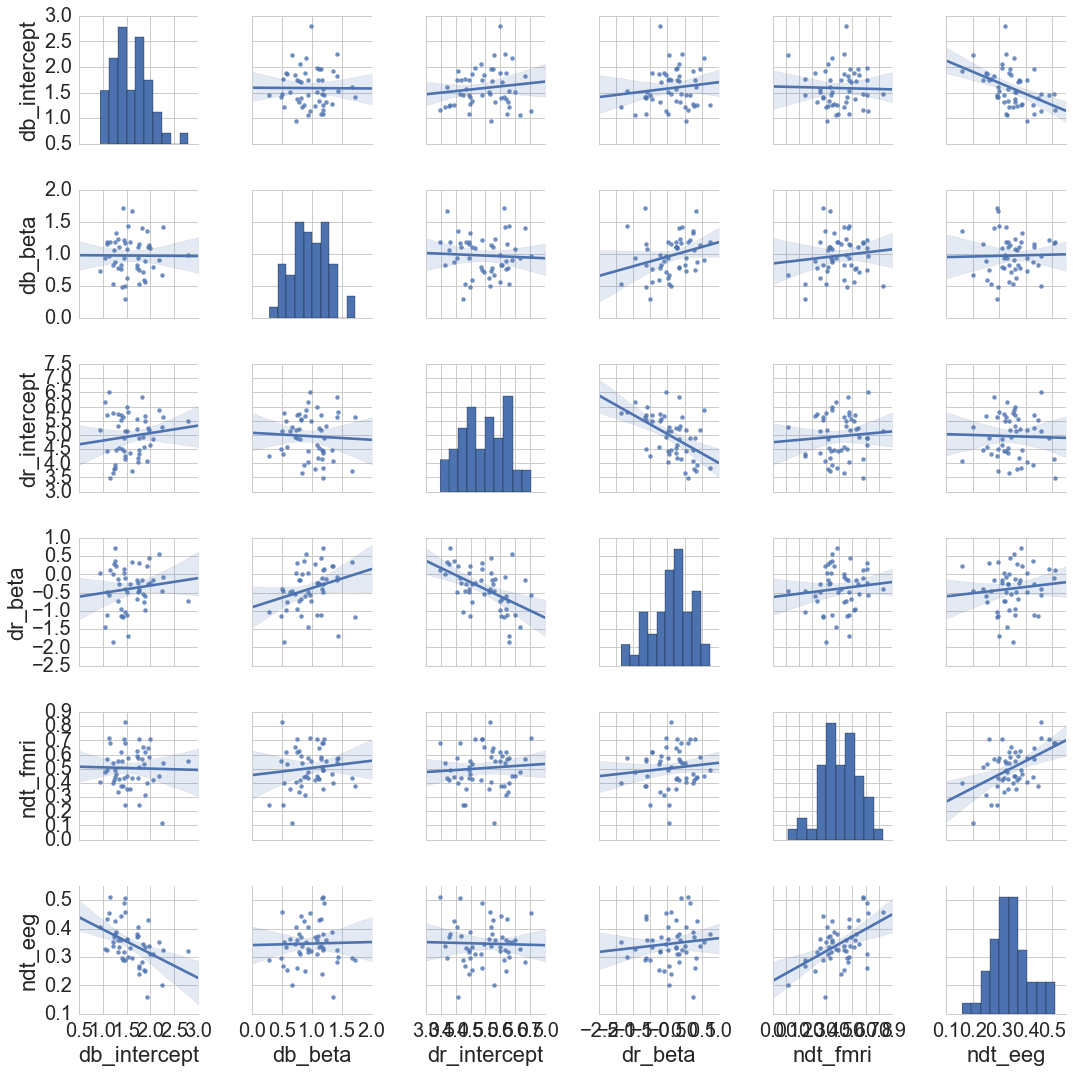

In [4]:
params = ['db_intercept', 'db_beta', 'dr_intercept', 'dr_beta',
          'ndt_fmri', 'ndt_eeg']
plot_corr(params=params, samples=samples, subjects=subjects)

## Group Effect Sizes

                       mean  se_mean    sd  2.5%   25%   50%   75%  97.5%  \
db_group_mu_beta       0.97  0.00076  0.05  0.86  0.93  0.97  1.00   1.08   
db_group_mu_intercept  1.59  0.00130  0.07  1.44  1.54  1.59  1.63   1.74   
dr_group_mu_beta      -0.39  0.00160  0.11 -0.61 -0.46 -0.39 -0.31  -0.17   
dr_group_mu_intercept  4.95  0.00210  0.14  4.68  4.86  4.95  5.04   5.24   

                        n_eff  Rhat  
db_group_mu_beta       5000.0   1.0  
db_group_mu_intercept  3362.0   1.0  
dr_group_mu_beta       5000.0   1.0  
dr_group_mu_intercept  4454.0   1.0  


../src/behavior.py:35: RuntimeWarning: divide by zero encountered in divide
  first = lam / np.sqrt(2 * np.pi * np.power(x - ndt, 3))
../src/behavior.py:38: RuntimeWarning: divide by zero encountered in divide
  second = np.exp(second_num / second_denom)
../src/behavior.py:39: RuntimeWarning: invalid value encountered in multiply
  return first * second


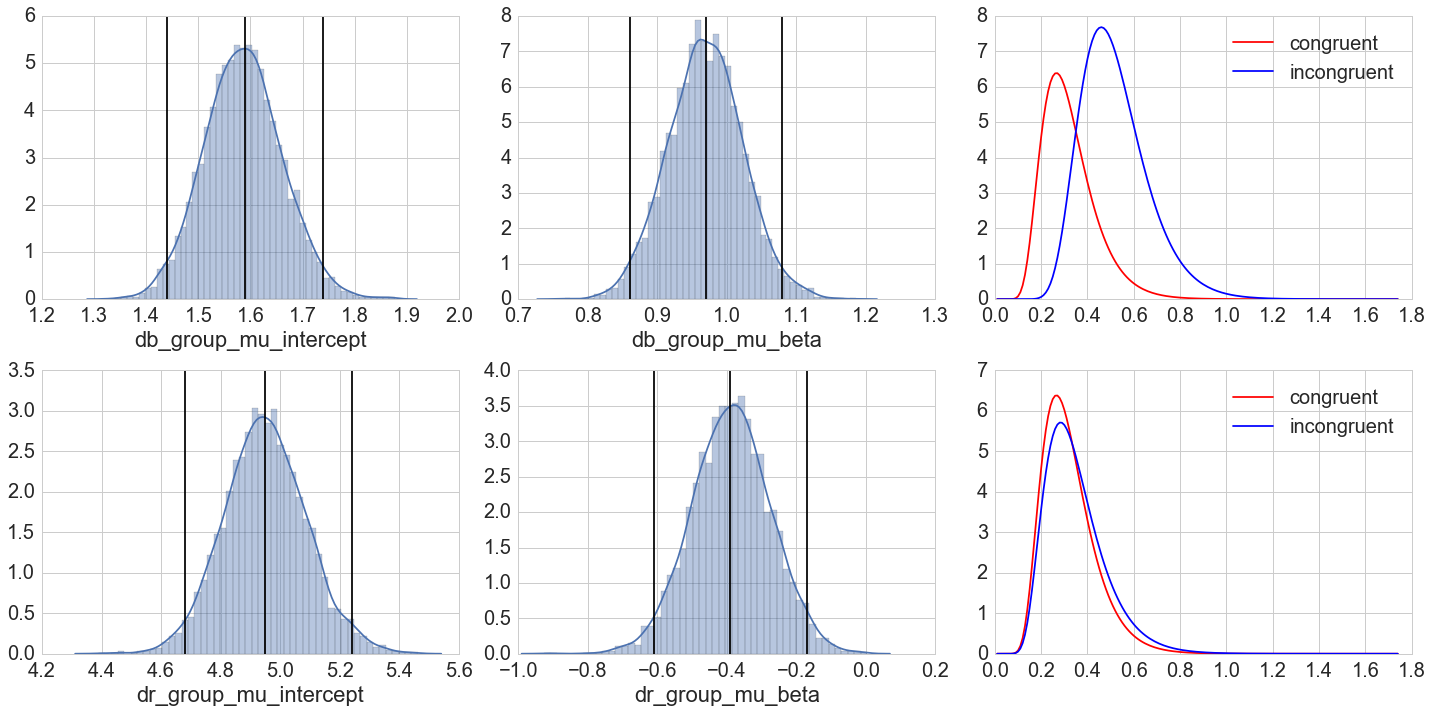

In [3]:
plot_group_es(samples, summary)